## Using Isolation Forest to Detect Criminally-Linked Properties

The goal of this notebook is to apply the Isolation Forest anomaly detection algorithm to the property data. The algorithm is particularly good at detecting anomalous data points in cases of extreme class imbalance. After normalizing the data and splitting into a training set and test set, I trained the first model.

Next, I manually selected a few features that, based on my experience investigating money-laundering and asset tracing, I thought would be most important and trained a model on just those.

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, recall_score, roc_auc_score
from sklearn.metrics import make_scorer, precision_score, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import seaborn as sns
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('dark')

#### Load Data and Remove Columns

In [2]:
# Read in the data
df = pd.read_hdf('../data/processed/bexar_true_labels.h5')
print("Number of properties:", len(df))

Number of properties: 5563


In [3]:
# Get criminal property rate
crim_prop_rate = 1 - (len(df[df['crim_prop']==0]) / len(df))
print("Rate is: {:.5%}".format(crim_prop_rate))

Rate is: 0.84487%


In [4]:
# Re-label the normal properties with 1 and the criminal ones with -1
df['binary_y'] = [1 if x==0 else -1 for x in df.crim_prop]
print(df.binary_y.value_counts())

 1    5516
-1      47
Name: binary_y, dtype: int64


In [5]:
# Normalize the data
X = df.iloc[:,1:-2]
X_norm = preprocessing.normalize(X)

y = df.binary_y

# Split the data into training and test
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(
    X_norm, y, test_size=0.33, random_state=42
)

#### UDFs

In [6]:
# Define function to plot resulting confusion matrix
def plot_confusion_matrix(conf_matrix, title, classes=['criminally-linked', 'normal'],
                          cmap=plt.cm.Oranges):
    """Plot confusion matrix with heatmap and classification statistics."""
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8,8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=18)
    plt.colorbar(pad=.12)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=11)
    plt.yticks(tick_marks, classes, rotation=45, fontsize=11)

    fmt = '.4%'
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment="top",
                 fontsize=16,
                 color="white" if conf_matrix[i, j] > thresh else "black")
    plt.ylabel('True label',fontsize=14, rotation=0)
    plt.xlabel('Predicted label',fontsize=14)
    
# Function for returning the model metrics
def metrics_iforest(y_true,y_pred):
    """Return model metrics."""
    print('Model recall is',recall_score(
        y_true,
        y_pred,
        zero_division=0,
        pos_label=-1
    ))
    print('Model precision is',precision_score(
        y_true,
        y_pred,
        zero_division=0,
        pos_label=-1
    ))

    print("Model AUC is", roc_auc_score(y_true, y_pred))
    
# Function for histograms of anomaly scores
def anomaly_plot(anomaly_scores,anomaly_scores_list,title):
    """Plot histograms of anomaly scores."""
    plt.figure(figsize=[15,9])
    plt.subplot(211)
    plt.hist(anomaly_scores,bins=100,log=False,color='royalblue')
    for xc in anomaly_scores_list:
        plt.axvline(x=xc,color='red',linestyle='--',linewidth=0.5,label='criminally-linked property')
    plt.title(title,fontsize=16)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),fontsize=14)
    plt.ylabel('Number of properties',fontsize=13)

    plt.subplot(212)
    plt.hist(anomaly_scores,bins=100,log=True,color='royalblue')
    for xc in anomaly_scores_list:
        plt.axvline(x=xc,color='red',linestyle='--',linewidth=0.5,label='criminally-linked property')
    plt.xlabel('Anomaly score',fontsize=13)
    plt.ylabel('Number of properties',fontsize=13)
    plt.title('{} (Log Scale)'.format(title),fontsize=16)

    plt.show()

#### Gridsearch

Isolation Forest is fairly robust to parameter changes, but changes in the contamination rate affect performance. I will gridsearch based on a range of contamination from 0.01 to 0.25 in leaps of 0.05. 

In [7]:
# Set what metrics to evaluate predictions
scoring = {
    'AUC': 'roc_auc',
    'Recall': make_scorer(recall_score,pos_label=-1),
    'Precision': make_scorer(precision_score,pos_label=-1)
}

gs = GridSearchCV(
    IsolationForest(max_samples=0.25, random_state=42,n_estimators=100),
    param_grid={'contamination': np.arange(0.01, 0.25, 0.05)},
    scoring=scoring, 
    refit='Recall',
    verbose=0,
    cv=3
)

# Fit to training data
gs.fit(X_train_norm,y_train_norm)

GridSearchCV(cv=3, error_score=nan,
             estimator=IsolationForest(behaviour='deprecated', bootstrap=False,
                                       contamination='auto', max_features=1.0,
                                       max_samples=0.25, n_estimators=100,
                                       n_jobs=None, random_state=42, verbose=0,
                                       warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'contamination': array([0.01, 0.06, 0.11, 0.16, 0.21])},
             pre_dispatch='2*n_jobs', refit='Recall', return_train_score=False,
             scoring={'AUC': 'roc_auc',
                      'Precision': make_scorer(precision_score, pos_label=-1),
                      'Recall': make_scorer(recall_score, pos_label=-1)},
             verbose=0)

In [8]:
print(gs.best_params_)

{'contamination': 0.21000000000000002}


##### Model Performance on Training Data

In [9]:
y_pred_train_gs = gs.predict(X_train_norm)
metrics_iforest(y_train_norm,y_pred_train_gs)

Model recall is 0.8695652173913043
Model precision is 0.02554278416347382
Model AUC is 0.831785848436473


[[  20    3]
 [ 763 2941]]


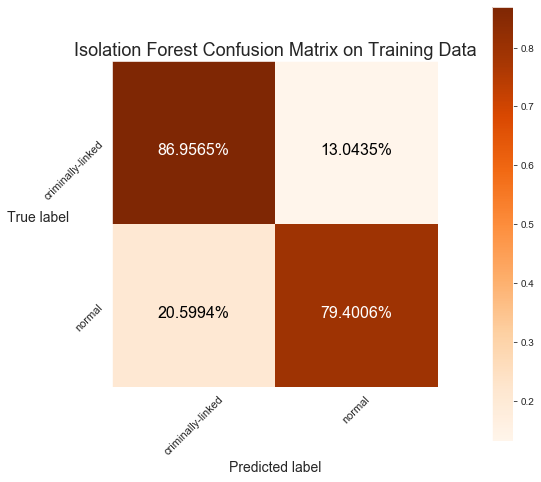

In [10]:
conf_matrix = confusion_matrix(y_train_norm, y_pred_train_gs)
print(conf_matrix)
plot_confusion_matrix(conf_matrix, title='Isolation Forest Confusion Matrix on Training Data')

Model recall is decent, but the precision is quite poor; the model is labeling >20% of innocent properties as criminal.

##### Model Performance on Test Data

In [11]:
y_pred_test_gs = gs.predict(X_test_norm)
metrics_iforest(y_test_norm,y_pred_test_gs)

Model recall is 0.7916666666666666
Model precision is 0.046798029556650245
Model AUC is 0.7890452538631346


[[  19    5]
 [ 387 1425]]


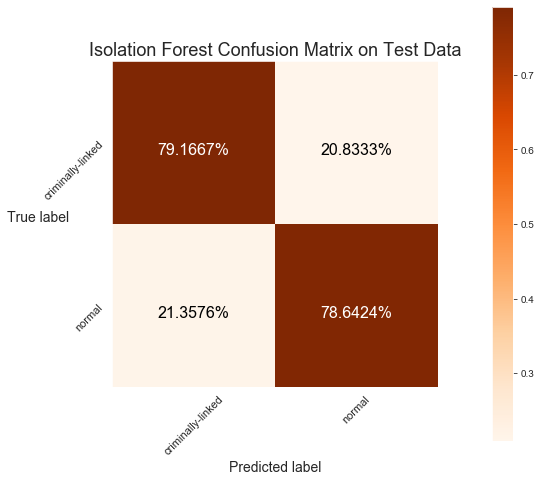

In [12]:
conf_matrix = confusion_matrix(y_test_norm, y_pred_test_gs)
print(conf_matrix)
plot_confusion_matrix(conf_matrix, title='Isolation Forest Confusion Matrix on Test Data')

Similar to performance on the training data, the model has a tremendous amount of false positives. While better than false negatives, were this model to be implemented to screen properties, it would waste a lot of manual labor on checking falsely-labeled properties.

Given the context of detecting money-laundering and ill-gotten funds, more false positives are acceptable to reduce false negatives, but the model produces far too many.

#### Visualize Distribution of Anomaly Scores

Sklearn's Isolation Forest provides anomaly scores for each property where the lower the score, the more anomalous the datapoint is.

##### Training Data

In [13]:
# Grab anomaly scores for criminally-linked properties
train_df = pd.DataFrame(X_train_norm)
y_train_series = y_train_norm.reset_index()
train_df['y_value'] = y_train_series.binary_y
train_df['anomaly_scores'] = gs.decision_function(X_train_norm)
anomaly_scores_list = train_df[train_df.y_value==-1]['anomaly_scores']

In [14]:
print("Mean score for outlier properties:",np.mean(anomaly_scores_list))
print("Mean score for normal properties:",np.mean(train_df[train_df.y_value==1]['anomaly_scores']))

Mean score for outlier properties: -0.052249827254644575
Mean score for normal properties: 0.01628741354777649


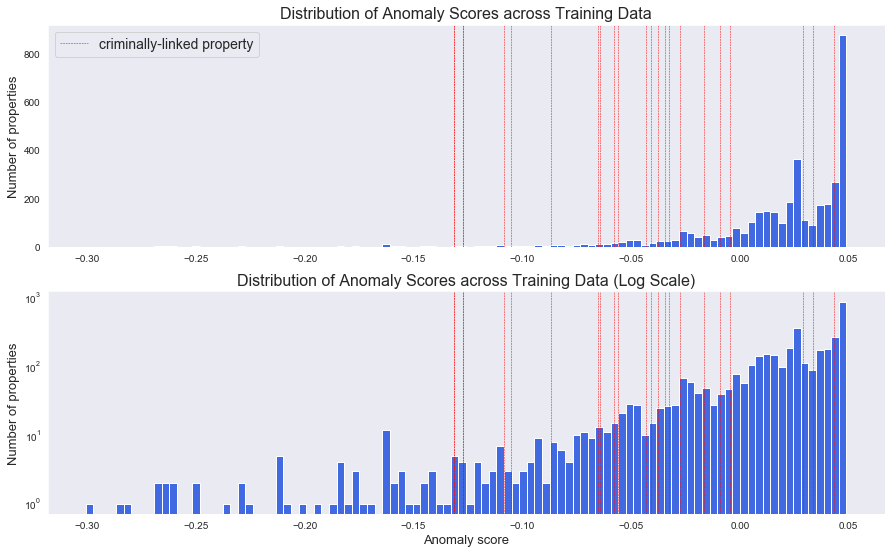

In [15]:
anomaly_plot(train_df['anomaly_scores'],
             anomaly_scores_list,
             title='Distribution of Anomaly Scores across Training Data')

##### Test Data

In [16]:
test_df = pd.DataFrame(X_test_norm)
y_test_series = y_test_norm.reset_index()
test_df['y_value'] = y_test_series.binary_y
test_df['anomaly_scores'] = gs.decision_function(X_test_norm)
anomaly_scores_list_test = test_df[test_df.y_value==-1]['anomaly_scores']

In [17]:
print("Mean score for outlier properties:",np.mean(anomaly_scores_list_test))
print("Mean score for normal properties:",np.mean(test_df[test_df.y_value==1]['anomaly_scores']))

Mean score for outlier properties: -0.03406306018822521
Mean score for normal properties: 0.016454369969430074


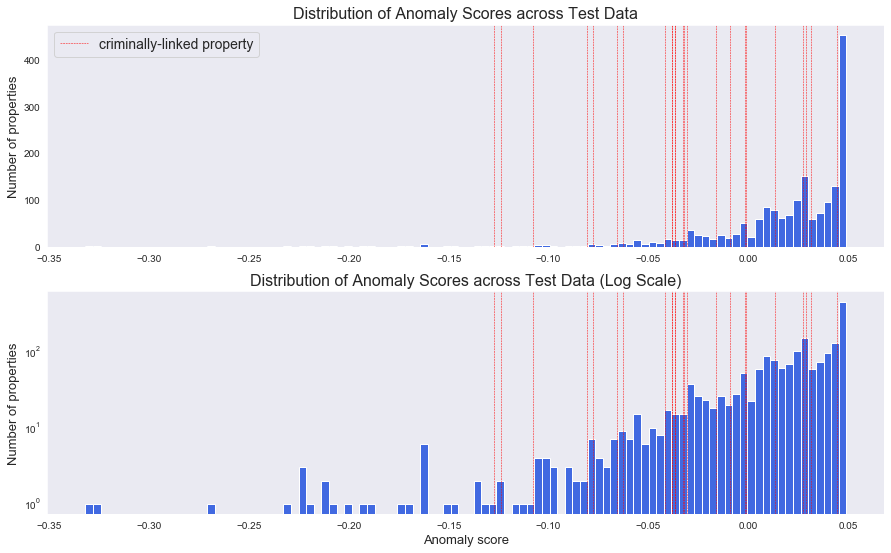

In [18]:
anomaly_plot(test_df['anomaly_scores'], 
             anomaly_scores_list_test, 
             title='Distribution of Anomaly Scores across Test Data'
)

The top plots give a sense of how skewed the distribution is and how relatively lower the anomaly scores for the criminally-linked properties are when compared to the greater population. The log scale histogram highlights just how many properties do have quite low anomaly scores, which are returned as false positives.

#### Model with Select Features

With `feature_importances_` not existing for Isolation Forest, I wanted to see if I could use my background in investigating money laundering to select a few features that would be the best indicators of "abnormal" properties.

In [19]:
# Grab specific columns
X_trim = X[['partial_owner','just_established_owner',
            'foreign_based_owner','out_of_state_owner',
            'owner_legal_person','owner_likely_company',
            'owner_owns_multiple','two_gto_reqs']]

# Normalize
X_trim_norm = preprocessing.normalize(X_trim)

# Split the data into train and test
X_train_trim, X_test_trim, y_train_trim, y_test_trim = train_test_split(
    X_trim_norm, y, test_size=0.33, random_state=42
)

In [20]:
scoring = {
    'AUC': 'roc_auc',
    'Recall': make_scorer(recall_score, pos_label=-1),
    'Precision': make_scorer(precision_score, pos_label=-1)
}

gs_trim = GridSearchCV(
    IsolationForest(max_samples=0.25, random_state=42,n_estimators=100),
    param_grid={'contamination': np.arange(0.01, 0.25, 0.05)},
    scoring=scoring, 
    refit='Recall',
    verbose=0,
    cv=3
)

# Fit to training data
gs_trim.fit(X_train_trim,y_train_trim)
print(gs_trim.best_params_)

{'contamination': 0.11}


##### Training Data

In [21]:
y_pred_train_gs_trim = gs_trim.predict(X_train_trim)
metrics_iforest(y_train_trim,y_pred_train_gs_trim)

Model recall is 0.782608695652174
Model precision is 0.0627177700348432
Model AUC is 0.8549922527936896


[[  18    5]
 [ 269 3435]]


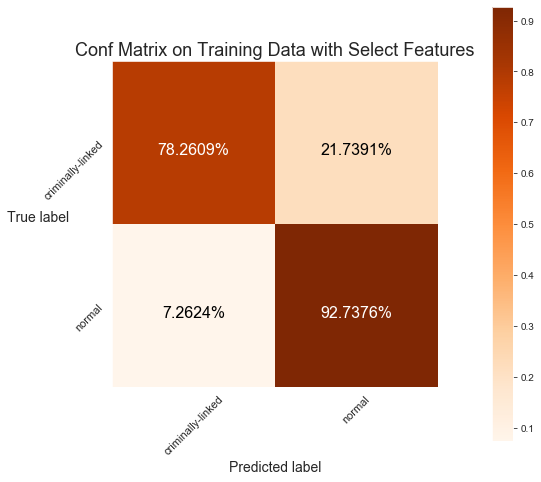

In [22]:
conf_matrix = confusion_matrix(y_train_trim, y_pred_train_gs_trim)
print(conf_matrix)
plot_confusion_matrix(conf_matrix, title='Conf Matrix on Training Data with Select Features')

Reducing the data to select features worsens the model's true positives by two properties, but massively improves the false positive rate (753 down to 269). Overall, model precision is still poor.

##### Test Data

In [23]:
y_pred_test_trim = gs_trim.predict(X_test_trim)
metrics_iforest(y_test_trim,y_pred_test_trim)

Model recall is 0.875
Model precision is 0.1510791366906475
Model AUC is 0.904939293598234


[[  21    3]
 [ 118 1694]]


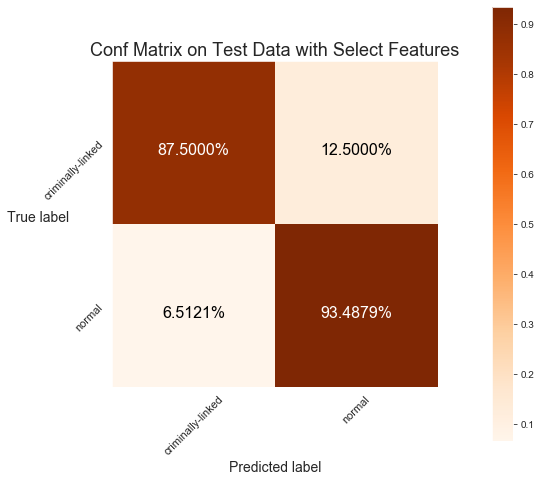

In [24]:
conf_matrix = confusion_matrix(y_test_trim, y_pred_test_trim)
print(conf_matrix)
plot_confusion_matrix(conf_matrix, title='Conf Matrix on Test Data with Select Features')

The model trained on select features performs better than the first on the test data both in terms of correct labels and reducing false positives.

#### Final Notes

- For both models, recall is strong, indicating the model is able to detect something anomalous about the criminal properties. However, model precision is awful, meaning it does so at the expense of many false positives.
- Selecting features based on my experience in the field improves model precision.
- There are many properties that the models find more "anomalous" than the true positives. This could indicate the criminals have done a good job of making their properties appear relatively "innocent" in the broad spectrum of residential property ownership in Bexar County.